In [1]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import json
import warnings
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report
from mlflow.models import infer_signature
from sklearn.dummy import DummyClassifier
import xgboost as xgb
from xgboost import plot_importance
from sklearn.linear_model import LogisticRegression
from challenge.constants import MLFLOW_EXPERIMENT_NAME, MLFLOW_TRACKING_URI, RANDOM_STATE
from challenge.pipeline.etl import etl_pipeline, calculate_target, get_min_diff

warnings.filterwarnings('ignore')

In [2]:
mlflow.set_tracking_uri(MLFLOW_TRACKING_URI)

In [3]:
try:
    mlflow.set_experiment(MLFLOW_EXPERIMENT_NAME)
except Exception as e:
    print(e)
    mlflow.create_experiment(MLFLOW_EXPERIMENT_NAME)

## 0. Load Data

In [4]:
data = pd.read_csv('../data/raw/data.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68206 entries, 0 to 68205
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Fecha-I    68206 non-null  object
 1   Vlo-I      68206 non-null  object
 2   Ori-I      68206 non-null  object
 3   Des-I      68206 non-null  object
 4   Emp-I      68206 non-null  object
 5   Fecha-O    68206 non-null  object
 6   Vlo-O      68205 non-null  object
 7   Ori-O      68206 non-null  object
 8   Des-O      68206 non-null  object
 9   Emp-O      68206 non-null  object
 10  DIA        68206 non-null  int64 
 11  MES        68206 non-null  int64 
 12  AÑO        68206 non-null  int64 
 13  DIANOM     68206 non-null  object
 14  TIPOVUELO  68206 non-null  object
 15  OPERA      68206 non-null  object
 16  SIGLAORI   68206 non-null  object
 17  SIGLADES   68206 non-null  object
dtypes: int64(3), object(15)
memory usage: 9.4+ MB


## 4. Training

### 4.a. Data Split (Training and Validation)

In [5]:
data['min_diff'] = data.apply(get_min_diff, axis=1)
data['delay'] = calculate_target(data, 'delay')

In [6]:
data.head()

,Fecha-I,Vlo-I,Ori-I,Des-I,Emp-I,Fecha-O,Vlo-O,Ori-O,Des-O,Emp-O,DIA,MES,AÑO,DIANOM,TIPOVUELO,OPERA,SIGLAORI,SIGLADES,min_diff,delay
0,2017-01-01 23:30:00,226,SCEL,KMIA,AAL,2017-01-01 23:33:00,226,SCEL,KMIA,AAL,1,1,2017,Domingo,I,American Airlines,Santiago,Miami,3.0,0
1,2017-01-02 23:30:00,226,SCEL,KMIA,AAL,2017-01-02 23:39:00,226,SCEL,KMIA,AAL,2,1,2017,Lunes,I,American Airlines,Santiago,Miami,9.0,0
2,2017-01-03 23:30:00,226,SCEL,KMIA,AAL,2017-01-03 23:39:00,226,SCEL,KMIA,AAL,3,1,2017,Martes,I,American Airlines,Santiago,Miami,9.0,0
3,2017-01-04 23:30:00,226,SCEL,KMIA,AAL,2017-01-04 23:33:00,226,SCEL,KMIA,AAL,4,1,2017,Miercoles,I,American Airlines,Santiago,Miami,3.0,0
4,2017-01-05 23:30:00,226,SCEL,KMIA,AAL,2017-01-05 23:28:00,226,SCEL,KMIA,AAL,5,1,2017,Jueves,I,American Airlines,Santiago,Miami,-2.0,0


In [7]:
cols_features = ['OPERA', 'MES', 'TIPOVUELO', 'SIGLADES', 'DIANOM', 'delay']

In [8]:
training_data = shuffle(data[cols_features], random_state = RANDOM_STATE)

In [9]:
unique_vals_per_feature = {}

for col in cols_features:
    unique_vals_per_feature[col] = list(data[col].unique())

unique_vals_per_feature["MES"] = [int(v) for v in unique_vals_per_feature["MES"]]
unique_vals_per_feature["delay"] = [int(v) for v in unique_vals_per_feature["delay"]] 

with open("../data/interim/unique_features.json", 'w') as f:
    json.dump(unique_vals_per_feature, f)

In [10]:
features, target = etl_pipeline(data, 'delay')

In [11]:
features.head()

,OPERA_Aerolineas Argentinas,OPERA_Aeromexico,OPERA_Air Canada,OPERA_Air France,OPERA_Alitalia,OPERA_American Airlines,OPERA_Austral,OPERA_Avianca,OPERA_British Airways,OPERA_Copa Air,...,SIGLADES_Ushuia,SIGLADES_Valdivia,SIGLADES_Washington,DIANOM_Domingo,DIANOM_Jueves,DIANOM_Lunes,DIANOM_Martes,DIANOM_Miercoles,DIANOM_Sabado,DIANOM_Viernes
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
2,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
3,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
4,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,True,False,False,False,False,False


In [12]:
target.head()

,delay
0,0
1,0
2,0
3,0
4,0


In [13]:
x_train, x_test, y_train, y_test = train_test_split(
    features,
    target, 
    test_size = 0.33,
    random_state = RANDOM_STATE,
    stratify = target
)

In [14]:
print(f"train shape: {x_train.shape} | test shape: {x_test.shape}")

train shape: (45698, 106) | test shape: (22508, 106)


In [15]:
y_train['delay'].value_counts('%')*100

delay
0    81.506849
1    18.493151
Name: proportion, dtype: float64

In [16]:
y_test['delay'].value_counts('%')*100

delay
0    81.504354
1    18.495646
Name: proportion, dtype: float64

In [17]:
with open("../data/interim/feature_columns.json", 'w') as f:
    json.dump({"feature_columns": list(x_train.columns)}, f)

### 4.b. Model Selection

In [18]:
signature = infer_signature(x_test, y_test)

In [19]:
eval_data = x_test.copy()
eval_data["label"] = y_test.copy()
eval_data.head()

,OPERA_Aerolineas Argentinas,OPERA_Aeromexico,OPERA_Air Canada,OPERA_Air France,OPERA_Alitalia,OPERA_American Airlines,OPERA_Austral,OPERA_Avianca,OPERA_British Airways,OPERA_Copa Air,...,SIGLADES_Valdivia,SIGLADES_Washington,DIANOM_Domingo,DIANOM_Jueves,DIANOM_Lunes,DIANOM_Martes,DIANOM_Miercoles,DIANOM_Sabado,DIANOM_Viernes,label
35760,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0
16344,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0
40013,False,False,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,0
26655,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,True,False,False,False,False,0
47723,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,0


In [20]:
train_data = x_train.copy()
train_data["label"] = y_train.copy()
train_data.head()

,OPERA_Aerolineas Argentinas,OPERA_Aeromexico,OPERA_Air Canada,OPERA_Air France,OPERA_Alitalia,OPERA_American Airlines,OPERA_Austral,OPERA_Avianca,OPERA_British Airways,OPERA_Copa Air,...,SIGLADES_Valdivia,SIGLADES_Washington,DIANOM_Domingo,DIANOM_Jueves,DIANOM_Lunes,DIANOM_Martes,DIANOM_Miercoles,DIANOM_Sabado,DIANOM_Viernes,label
53264,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0
64357,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,1
29154,False,False,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,0
8832,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,0
1749,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,0


In [21]:
eval_config = {
    "targets": "label",
    "model_type":"classifier",
    "evaluator_config": {
        'explainability_algorithm': 'permutation',
        'metric_prefix': 'evaluation_'
    }
}

In [22]:
train_config = {
    "targets": "label",
    "model_type":"classifier",
    "evaluator_config": {
        'explainability_algorithm': 'permutation',
        'metric_prefix': 'training_'
    }
}

#### 4.b.0 Baseline Model

In [23]:
desc = "Baseline Model"
run_name = "Baseline Model"
with mlflow.start_run(description=desc, run_name=run_name) as _:
    baseline_model = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE).fit(x_train, y_train)
    
    baseline_model_uri = mlflow.sklearn.log_model(
        baseline_model, "model", signature=signature
    ).model_uri

mlflow.end_run()

#### 4.b.i. XGBoost

In [24]:
desc = "XGBoost"
with mlflow.start_run(description=desc) as _:
    xgb_model = xgb.XGBClassifier(random_state=RANDOM_STATE, learning_rate=0.01)
    xgb_model.fit(x_train, y_train)
    
    candidate_model_uri = mlflow.sklearn.log_model(
        xgb_model, "candidate_model", signature=signature
    ).model_uri
    
    mlflow.evaluate(
        candidate_model_uri,
        eval_data,
        baseline_model=baseline_model_uri,
        **eval_config
    )
    mlflow.evaluate(
        candidate_model_uri,
        train_data,
        baseline_model=baseline_model_uri,
        **train_config
    )
mlflow.end_run()

2024/03/29 18:49:22 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:49:22 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:49:22 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:49:22 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:49:22 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:49:26 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:49:27 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:49:27 INFO mlflow.models.evaluation.default_evaluator: Computing model

2024/03/29 18:49:37 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:49:37 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:49:37 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:49:38 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:49:38 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:49:42 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:49:42 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:49:42 INFO mlflow.models.evaluation.default_evaluator: Computing model

<Figure size 1050x700 with 0 Axes>

In [25]:
xgboost_y_preds = xgb_model.predict(x_test)
xgboost_y_preds = [1 if y_pred > 0.5 else 0 for y_pred in xgboost_y_preds]

In [26]:
confusion_matrix(y_test, xgboost_y_preds)

array([[18338,     7],
       [ 4149,    14]])

In [27]:
pd.DataFrame(classification_report(y_test, xgboost_y_preds, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.815493,0.666667,0.815355,0.741080,0.787967
recall,0.999618,0.003363,0.815355,0.501491,0.815355
f1-score,0.898217,0.006692,0.815355,0.452455,0.733324
support,18345.000000,4163.000000,0.815355,22508.000000,22508.000000


#### 4.b.ii. Logistic Regression

In [28]:
desc = "Logistic Regression"
with mlflow.start_run(description=desc) as _:
    reg_model = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
    reg_model.fit(x_train, y_train)
    candidate_model_uri = mlflow.sklearn.log_model(
        reg_model, "candidate_model", signature=signature
    ).model_uri
    
    mlflow.evaluate(
        candidate_model_uri,
        eval_data,
        baseline_model=baseline_model_uri,
        **eval_config
    )
    mlflow.evaluate(
        candidate_model_uri,
        train_data,
        baseline_model=baseline_model_uri,
        **train_config
    )
mlflow.end_run()

2024/03/29 18:50:00 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:50:00 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:50:00 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:50:00 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:50:00 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:50:05 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:50:05 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:50:05 INFO mlflow.models.evaluation.default_evaluator: Computing model

2024/03/29 18:50:15 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:50:15 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:50:16 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:50:16 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:50:16 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:50:20 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:50:20 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:50:20 INFO mlflow.models.evaluation.default_evaluator: Computing model

In [29]:
reg_y_preds = reg_model.predict(x_test)

In [30]:
confusion_matrix(y_test, reg_y_preds)

array([[18188,   157],
       [ 4012,   151]])

In [31]:
pd.DataFrame(classification_report(y_test, reg_y_preds, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.819279,0.490260,0.814777,0.654770,0.758425
recall,0.991442,0.036272,0.814777,0.513857,0.814777
f1-score,0.897176,0.067546,0.814777,0.482361,0.743731
support,18345.000000,4163.000000,0.814777,22508.000000,22508.000000


## 5. Data Analysis: Third Sight

### Feature Importance

<Figure size 1050x700 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

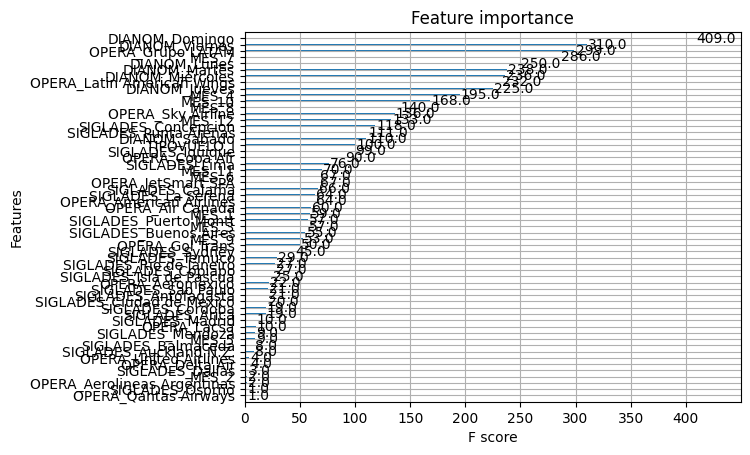

In [32]:
plt.figure(figsize = (10,5))
plot_importance(xgb_model)
plt.show()

In [33]:
top_10_features = [
    "OPERA_Latin American Wings", 
    "MES_7",
    "MES_10",
    "OPERA_Grupo LATAM",
    "MES_12",
    "TIPOVUELO_I",
    "MES_4",
    "MES_11",
    "OPERA_Sky Airline",
    "OPERA_Copa Air"
]

### Data Balance

In [34]:
n_y0 = len(y_train[y_train == 0])
n_y1 = len(y_train[y_train == 1])
scale = n_y0/n_y1
print(scale)

1.0


## 6. Training with Improvement

### 6.a. Data Split

In [35]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(
    features[top_10_features], 
    target, 
    test_size = 0.33, 
    random_state = RANDOM_STATE,
    stratify = target
)

### 6.b. Model Selection

In [36]:
signature = infer_signature(x_test2, y_test2)

In [37]:
eval_data = x_test2.copy()
eval_data["label"] = y_test2.copy()
eval_data.head()

,OPERA_Latin American Wings,MES_7,MES_10,OPERA_Grupo LATAM,MES_12,TIPOVUELO_I,MES_4,MES_11,OPERA_Sky Airline,OPERA_Copa Air,label
35760,False,True,False,True,False,False,False,False,False,False,0
16344,False,False,False,True,False,True,False,False,False,False,0
40013,False,False,False,False,False,False,False,False,True,False,0
26655,False,False,False,True,False,True,False,False,False,False,0
47723,False,False,False,True,False,False,False,False,False,False,0


In [38]:
train_data = x_train2.copy()
train_data["label"] = y_train2.copy()
train_data.head()

,OPERA_Latin American Wings,MES_7,MES_10,OPERA_Grupo LATAM,MES_12,TIPOVUELO_I,MES_4,MES_11,OPERA_Sky Airline,OPERA_Copa Air,label
53264,False,False,True,True,False,False,False,False,False,False,0
64357,False,False,False,False,True,True,False,False,True,False,1
29154,False,False,False,False,False,False,False,False,True,False,0
8832,False,False,False,True,False,False,False,False,False,False,0
1749,False,False,False,False,False,False,False,False,True,False,0


### 6.b.0 Baseline Model

In [39]:
desc = "Baseline Model Top 10 features"
run_name = "Baseline Model Top 10 features"
with mlflow.start_run(description=desc, run_name=run_name) as _:
    baseline_model = DummyClassifier(strategy="uniform", random_state=RANDOM_STATE).fit(x_train2, y_train2)
    
    baseline_model_uri = mlflow.sklearn.log_model(
        baseline_model, "model", signature=signature
    ).model_uri

mlflow.end_run()

#### 6.b.i. XGBoost with Feature Importance and with Balance

In [40]:
desc = "XGBoost with Feature Importance and with Balance"
with mlflow.start_run(description=desc) as _:
    xgb_model_2 = xgb.XGBClassifier(random_state=RANDOM_STATE, learning_rate=0.01, scale_pos_weight = scale)
    xgb_model_2.fit(x_train2, y_train2)
    
    candidate_model_uri = mlflow.sklearn.log_model(
        xgb_model_2, "candidate_model", signature=signature
    ).model_uri
    
    mlflow.evaluate(
        candidate_model_uri,
        eval_data,
        baseline_model=baseline_model_uri,
        **eval_config
    )
    mlflow.evaluate(
        candidate_model_uri,
        train_data,
        baseline_model=baseline_model_uri,
        **train_config
    )
mlflow.end_run()

2024/03/29 18:50:45 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:50:45 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:50:45 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:50:45 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:50:45 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:50:48 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:50:48 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:50:48 INFO mlflow.models.evaluation.default_evaluator: Computing model

2024/03/29 18:50:59 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:50:59 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:50:59 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:50:59 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:50:59 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:51:03 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:51:03 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:51:03 INFO mlflow.models.evaluation.default_evaluator: Computing model

In [41]:
xgboost_y_preds_2 = xgb_model_2.predict(x_test2)

In [42]:
confusion_matrix(y_test2, xgboost_y_preds_2)

array([[18336,     9],
       [ 4137,    26]])

In [43]:
pd.DataFrame(classification_report(y_test2, xgboost_y_preds_2, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.815912,0.742857,0.815799,0.779385,0.802400
recall,0.999509,0.006245,0.815799,0.502877,0.815799
f1-score,0.898427,0.012387,0.815799,0.455407,0.734548
support,18345.000000,4163.000000,0.815799,22508.000000,22508.000000


#### 6.b.ii. XGBoost with Feature Importance but without Balance

In [44]:
desc = "XGBoost with Feature Importance but without Balance"
with mlflow.start_run(description=desc) as _:
    xgb_model_3 = xgb.XGBClassifier(random_state=RANDOM_STATE, learning_rate=0.01)
    xgb_model_3.fit(x_train2, y_train2)
    
    candidate_model_uri = mlflow.sklearn.log_model(
        xgb_model_3, "candidate_model", signature=signature
    ).model_uri
    
    mlflow.evaluate(
        candidate_model_uri,
        eval_data,
        baseline_model=baseline_model_uri,
        **eval_config
    )
    mlflow.evaluate(
        candidate_model_uri,
        train_data,
        baseline_model=baseline_model_uri,
        **train_config
    )
mlflow.end_run()

2024/03/29 18:51:20 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:51:20 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:51:20 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:51:20 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:51:20 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:51:24 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:51:24 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:51:24 INFO mlflow.models.evaluation.default_evaluator: Computing model

2024/03/29 18:51:34 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:51:34 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:51:34 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:51:34 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:51:34 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:51:38 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:51:38 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:51:38 INFO mlflow.models.evaluation.default_evaluator: Computing model

In [45]:
xgboost_y_preds_3 = xgb_model_3.predict(x_test2)

In [46]:
confusion_matrix(y_test2, xgboost_y_preds_3)

array([[18336,     9],
       [ 4137,    26]])

In [47]:
pd.DataFrame(classification_report(y_test2, xgboost_y_preds_3, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.815912,0.742857,0.815799,0.779385,0.802400
recall,0.999509,0.006245,0.815799,0.502877,0.815799
f1-score,0.898427,0.012387,0.815799,0.455407,0.734548
support,18345.000000,4163.000000,0.815799,22508.000000,22508.000000


#### 6.b.iii. Logistic Regression with Feature Importante and with Balance

In [48]:
desc = "Logistic Regression with Feature Importante and with Balance"
with mlflow.start_run(description=desc) as _:
    reg_model_2 = LogisticRegression(
        class_weight={1: n_y0/len(y_train), 0: n_y1/len(y_train)},
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    reg_model_2.fit(x_train2, y_train2)
    
    candidate_model_uri = mlflow.sklearn.log_model(
        reg_model_2, "candidate_model", signature=signature
    ).model_uri
    
    mlflow.evaluate(
        candidate_model_uri,
        eval_data,
        baseline_model=baseline_model_uri,
        **eval_config
    )
    mlflow.evaluate(
        candidate_model_uri,
        train_data,
        baseline_model=baseline_model_uri,
        **train_config
    )
mlflow.end_run()

2024/03/29 18:51:56 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:51:56 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:51:56 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:51:56 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:51:56 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:51:59 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:52:00 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:52:00 INFO mlflow.models.evaluation.default_evaluator: Computing model

2024/03/29 18:52:08 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:52:08 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:52:08 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:52:08 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:52:08 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:52:12 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:52:12 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:52:13 INFO mlflow.models.evaluation.default_evaluator: Computing model

In [49]:
reg_y_preds_2 = reg_model_2.predict(x_test2)

In [50]:
confusion_matrix(y_test2, reg_y_preds_2)

array([[18300,    45],
       [ 4099,    64]])

In [51]:
pd.DataFrame(classification_report(y_test2, reg_y_preds_2, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.817001,0.587156,0.815888,0.702078,0.774489
recall,0.997547,0.015374,0.815888,0.506460,0.815888
f1-score,0.898292,0.029963,0.815888,0.464127,0.737689
support,18345.000000,4163.000000,0.815888,22508.000000,22508.000000


#### 6.b.iv. Logistic Regression with Feature Importante but without Balance

In [52]:
desc = "Logistic Regression with Feature Importante but without Balance"
with mlflow.start_run(description=desc) as _:
    reg_model_3 = LogisticRegression(random_state=RANDOM_STATE, n_jobs=-1)
    reg_model_3.fit(x_train2, y_train2)

    candidate_model_uri = mlflow.sklearn.log_model(
        reg_model_3, "candidate_model", signature=signature
    ).model_uri
    
    mlflow.evaluate(
        candidate_model_uri,
        eval_data,
        baseline_model=baseline_model_uri,
        **eval_config
    )
    mlflow.evaluate(
        candidate_model_uri,
        train_data,
        baseline_model=baseline_model_uri,
        **train_config
    )
mlflow.end_run()

2024/03/29 18:52:29 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:52:29 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:52:29 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:52:29 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:52:29 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:52:33 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:52:33 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:52:33 INFO mlflow.models.evaluation.default_evaluator: Computing model

2024/03/29 18:52:42 INFO mlflow.models.evaluation.base: Evaluating the model with the default evaluator.
2024/03/29 18:52:42 INFO mlflow.models.evaluation.default_evaluator: Evaluating candidate model:
2024/03/29 18:52:42 INFO mlflow.models.evaluation.default_evaluator: Computing model predictions.
2024/03/29 18:52:42 INFO mlflow.models.evaluation.default_evaluator: The evaluation dataset is inferred as binary dataset, positive label is 1, negative label is 0.
2024/03/29 18:52:42 INFO mlflow.models.evaluation.default_evaluator: Testing metrics on first row...
2024/03/29 18:52:46 WARNING mlflow.models.evaluation.default_evaluator: Skip logging model explainability insights because the shap explainer permutation requires all feature values to be numeric, and each feature column must only contain scalar values.
2024/03/29 18:52:46 INFO mlflow.models.evaluation.default_evaluator: Evaluating baseline model:
2024/03/29 18:52:46 INFO mlflow.models.evaluation.default_evaluator: Computing model

In [53]:
reg_y_preds_3 = reg_model_3.predict(x_test2)

In [54]:
confusion_matrix(y_test2, reg_y_preds_3)

array([[18300,    45],
       [ 4099,    64]])

In [55]:
pd.DataFrame(classification_report(y_test2, reg_y_preds_3, output_dict=True))

,0,1,accuracy,macro avg,weighted avg
precision,0.817001,0.587156,0.815888,0.702078,0.774489
recall,0.997547,0.015374,0.815888,0.506460,0.815888
f1-score,0.898292,0.029963,0.815888,0.464127,0.737689
support,18345.000000,4163.000000,0.815888,22508.000000,22508.000000


## 7. Data Science Conclusions

By looking at the results of the 6 trained models, it can be determined:
- There is no noticeable difference in results between XGBoost and LogisticRegression.
- Does not decrease the performance of the model by reducing the features to the 10 most important.
- Improves the model's performance when balancing classes, since it increases the recall of class "1".

**With this, the model to be productive must be the one that is trained with the top 10 features and class balancing, but which one?**